# EMO1 - series areales
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 13-08-2023*<br>

**Introducción:**<br>


In [5]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from tqdm.notebook import tqdm
import xarray as xr
import rioxarray
from shapely.geometry import mapping
import cartopy.crs as ccrs
import cartopy.feature as cf

## Configuración

In [3]:
# directorios con los datos de EFAS
path_EFAS = 'C:/Users/jcr693/Documents/EFASv5/'
path_maps = f'{path_EFAS}iberia/maps/'
path_tables = f'{path_EFAS}iberia/tables/'
path_meteo = f'{path_EFAS}iberia/meteo/'

# directorio con las capas GIS
path_GIS = '../data/anuario_aforos/GIS/'

# sistema de referencia de coordenadas de todos los datos
crs = 'epsg:4326'

# directorio donde guardar los resultados
path_out = '../data/EFASv5/atributos/'
if os.path.exists(path_out) is False:
    os.mkdir(path_out)

## Subcuencas

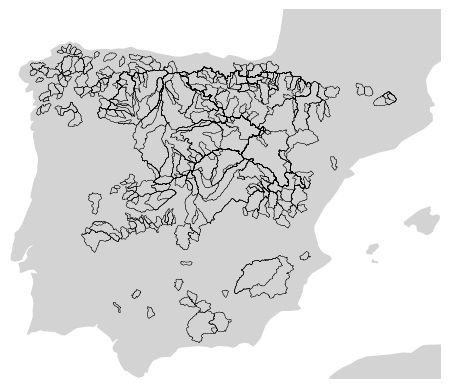

In [6]:
# cargar subcuencas
subcuencas = gpd.read_file(f'{path_GIS}subcuencas_epsg4326.shp')
subcuencas.set_index('gauge_id', drop=False, inplace=True)

# plot subcuencas
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
subcuencas.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.3);
ax.axis('off');

## Mapas

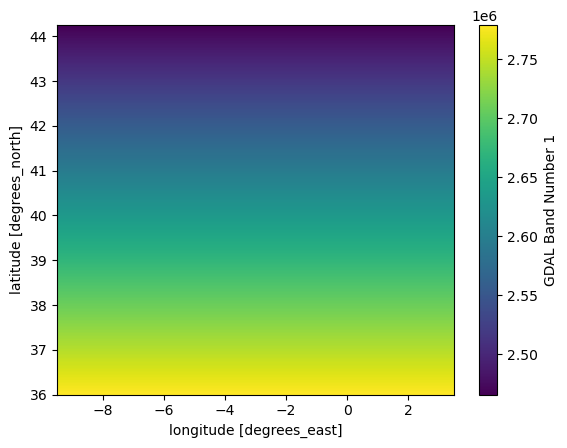

In [8]:
area = xr.open_mfdataset(glob.glob(f'{path_maps}pixarea*.nc'))['Band1'].compute()

area.plot();

## Meteo

In [10]:
for var in tqdm(['pr', 'ta', 'e0']):
    
    # cargar los datos 
    da = xr.open_mfdataset(glob.glob(f'{path_meteo}{var}/EMO*{var}*.nc'), chunks='auto')[var]
    da.close()
    
    # convertir en volumen
    if var in ['pr', 'ta', 'e0']:
        da = da * area * 1e-3
    
    # definir dimensiones con las coordenadas
    da = da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
    
    # definir sistema de coordenadas
    da = da.rio.write_crs('epsg:4326')
    
    # cellsize = da.lon.diff('lon').mean().data
    
    # calcular series areales
    df = pd.DataFrame(index=da.time.data, columns=subcuencas.index)
    series = {'mean': df.copy(),
              'std': df.copy()}
    for id in tqdm(subcuencas.index):
        poligono = subcuencas.loc[[id]]
        da_sub = da.rio.clip(poligono.geometry.apply(mapping), poligono.crs, drop=True)
        # buffer = poligono.buffer(cellsize / 3)
        # da_sub = da.rio.clip(buffer.geometry.apply(mapping), buffer.crs, drop=True)
        da_sub = da_sub.compute()
        series['mean'][id] = da_sub.mean(['lon', 'lat']).to_pandas()
        series['std'][id] = da_sub.std(['lon', 'lat']).to_pandas()
        del poligono, da_sub#, ts, buffer
    
    # exportar series areales
    for key, df in series.items():
        df.columns = df.columns.astype(str)
        df.index.name = 'date'
        df.to_parquet(f'../data/EMO1/{var}_areal_{key}.parquet')
    
    del da, series

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

In [ ]:
# fig, ax = plt.subplots(figsize=(6, 5))
# (da.mean('time') * 365).plot(ax=ax)
# subcuencas.boundary.plot(color='w', lw=.5, ax=ax);

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
(da_sub.mean('time') * 365).plot(ax=ax)
poligono.boundary.plot(color='k', lw=.5, ax=ax)
buffer.boundary.plot(color='k', lw=.5, ax=ax)
xmin, ymin, xmax, ymax = buffer.total_bounds
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

### Temperatura

In [ ]:
var = 'ta'

# cargar los datos 
ta = xr.open_mfdataset(glob.glob(f'{path_EMO}{var}/EMO*{var}*.nc'), chunks='auto')[var]
ta.close()

# definir dimensiones con las coordenadas
ta = ta.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
# definir sistema de coordenadas
ta = ta.rio.write_crs('epsg:4326')

# cellsize = ta.lon.diff('lon').mean().data

# calcular series areales
ta_mean = pd.DataFrame(index=ta.time.data, columns=subcuencas.index)
ta_std = ta_mean.copy()
for id in tqdm(subcuencas.index):
    poligono = subcuencas.loc[[id]]
    ta_sub = ta.rio.clip(poligono.geometry.apply(mapping), poligono.crs, drop=True)
    # buffer = poligono.buffer(cellsize / 3)
    # ta_sub = ta.rio.clip(buffer.geometry.apply(mapping), buffer.crs, drop=True)
    ta_sub = ta_sub.compute()
    ta_mean[id] = ta_sub.mean(['lon', 'lat']).to_pandas()
    ta_std[id] = ta_sub.std(['lon', 'lat']).to_pandas()
    #series[id] = da_sub.mean(['x', 'y']).to_pandas()

    del poligono, ta_sub #, buffer

In [ ]:
# exportar series areales
ta_mean.columns = ta_mean.columns.astype(str)
ta_mean.index.name = 'date'
ta_mean.to_parquet(f'../data/EMO1/{var}_areal_mean.parquet')

# exportar series areales
ta_std.columns = ta_std.columns.astype(str)
ta_std.index.name = 'date'
ta_std.to_parquet(f'../data/EMO1/{var}_areal_std.parquet')

del ta

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
(ta_sub.mean('time') * 365).plot(ax=ax)
poligono.boundary.plot(color='k', lw=.5, ax=ax)
buffer.boundary.plot(color='k', lw=.5, ax=ax)
xmin, ymin, xmax, ymax = buffer.total_bounds
ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))

**Recortar**

In [ ]:
ts.to_pandas()

In [ ]:
plt.plot(ts)

In [ ]:
# Step 3: Compute polygon averages using groupby
polygon_averages = dataset.groupby(joined.index).mean(dim='spatial_dim')  # Replace 'spatial_dim' with the actual spatial dimension name in your Dataset

# 'polygon_averages' now contains the average value for each polygon in the GeoDataFrame.

# If needed, you can now merge the polygon averages back to the GeoDataFrame
gdf_with_averages = gdf.merge(polygon_averages, left_index=True, right_index=True)

# The resulting 'gdf_with_averages' will contain both the original polygon information and the computed averages.

Note that in Step 3, you need to replace 'spatial_dim' with the actual spatial dimension name in your xarray.Dataset. For example, if your xarray.Dataset has latitude and longitude dimensions, you can use .mean(dim=['latitude', 'longitude']) to compute the average over those dimensions.

Also, keep in mind that the spatial join operation might result in polygons being assigned to multiple grid cells if they intersect multiple cells. In such cases, the average is computed for each grid cell that the polygon intersects, and the result is a xarray.Dataset with multi-level indices, indicating the polygon ID and grid cell index.